<p style="font-size: 36px"><strong>Coding Challenge Data Science Position</strong></p>

by *Julian Dörr*

# Load modules 

In [1]:
from util import plot_describe
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm

# Inspect and clean data

In [2]:
df = pd.read_csv('./data/CustomerData_LeadGenerator.csv', sep=',')

Are there any missings?

In [3]:
df.apply(lambda x: x.isnull().sum())

fakeID                                            0
b_specialisation_i                                0
b_specialisation_h                                0
b_specialisation_g                                0
b_specialisation_f                                0
b_specialisation_e                                0
b_specialisation_d                                0
b_specialisation_c                                0
b_specialisation_b                                0
b_specialisation_a                                0
b_specialisation_j                                0
q_OpeningDays                                     0
q_OpeningHours                                    0
q_2017 Average Household Size                     0
q_2017 Total Households                           0
q_2017 HHs: 5th Quintile (68.759 and above)       0
q_5th Quint by Total HH                           0
q_2017 Purchasing Power: Per Capita               0
q_2017 Total Population                           0
q_2017 Pop 1

No missing data.

What are the data types?

In [4]:
df.dtypes

fakeID                                             object
b_specialisation_i                                  int64
b_specialisation_h                                  int64
b_specialisation_g                                  int64
b_specialisation_f                                  int64
b_specialisation_e                                  int64
b_specialisation_d                                  int64
b_specialisation_c                                  int64
b_specialisation_b                                  int64
b_specialisation_a                                  int64
b_specialisation_j                                  int64
q_OpeningDays                                       int64
q_OpeningHours                                     object
q_2017 Average Household Size                     float64
q_2017 Total Households                             int64
q_2017 HHs: 5th Quintile (68.759 and above)         int64
q_5th Quint by Total HH                           float64
q_2017 Purchas

Why is `q_OpeningHours` read as string?

In [5]:
df.q_OpeningHours.value_counts(dropna=False).sort_index(ascending=False)

q_OpeningHours
ject       1
9         12
8         17
7.5        1
7          7
        ... 
11.5       1
11         3
10.5       1
10        17
0       1003
Name: count, Length: 117, dtype: int64

'ject' seems to be a data quality issue. Replace 'ject' by NULL and impute later on by a nearest neighbor method or similar if necessary.

In [6]:
df.loc[df.q_OpeningHours=='ject', 'q_OpeningHours'] = np.nan
# Define 'q_OpeningHours' as float
df['q_OpeningHours'] = df.q_OpeningHours.astype(dtype='float64')

Let's visually inspect the data to spot potential outliers or other irregularities.

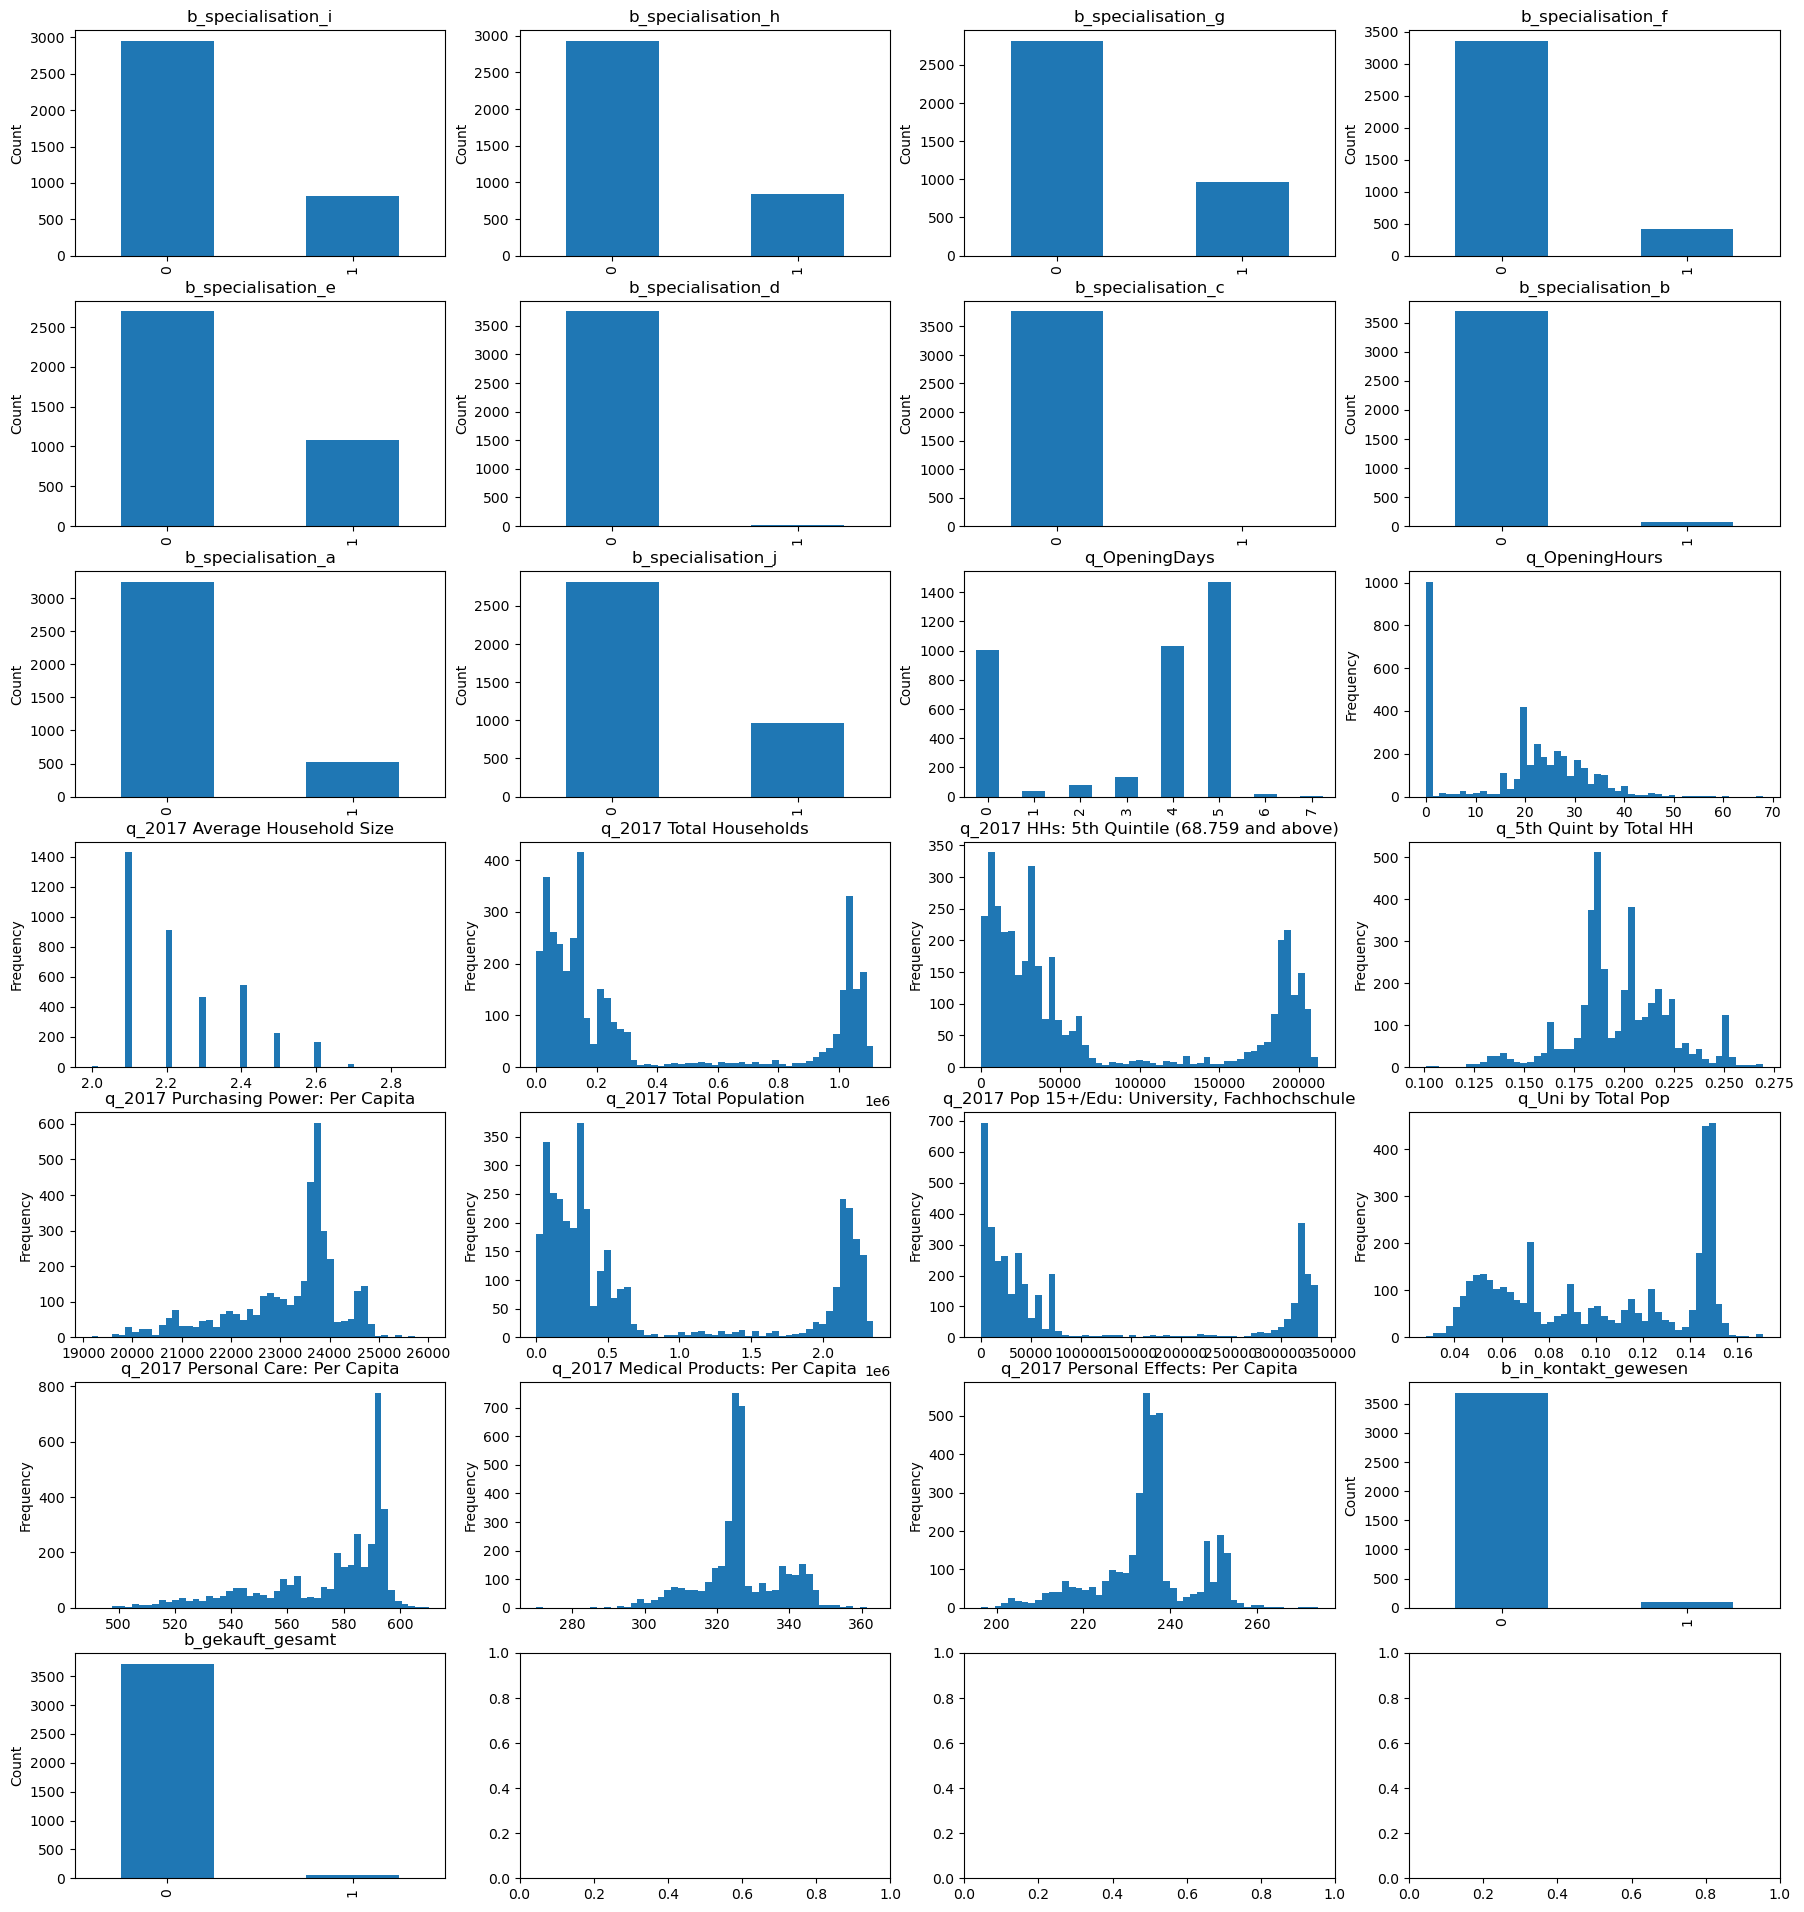

In [7]:
plot_describe(df, columns=df.drop(columns='fakeID').columns)

Some of the specialisation features (`b_specialisation_d`, `b_specialisation_c`, `b_specialisation_b`) as well as `b_in_kontakt_gewesen` and `b_gekauft_gesamt` are highly imbalanced. Also some of the demographic features seem to be bimodal.

Let's understand better what `b_in_kontakt_gewesen` and `b_gekauft_gesamt` represent. How do `b_in_kontakt_gewesen` and `b_gekauft_gesamt` relate to one another in a simple cross table?

In [8]:
pd.crosstab(df['b_gekauft_gesamt'], df['b_in_kontakt_gewesen'], margins=True)

b_in_kontakt_gewesen,0,1,All
b_gekauft_gesamt,,,
0,3678,38,3716
1,0,57,57
All,3678,95,3773


Findings:
- we see that 3.678 observations have not been contacted (treated). None of these have made a purchase
- moreover, we see that 95 observations have been contacted. 57 of those which have been contacted made a purchase
- at first, this signals that generating leads (get in touch with potential customers), is a strong predictor for an ultimate purchase
- this raises the question which potential customers to prioritize in lead generation?

# Project formulation

To tackle this question we aim at developing a classification model that allows to predict how likely it is that a potential customer makes a purchase if he/she has been contacted before based on the potential customer's demographics (features). In other words, how can resources (contacting potential customers) be spent most efficiently.
For this purpose, we
- drop `b_in_kontakt_gewesen` as feature since this information will not be available at inference 
- reduce the dataset to only those observations which have been contacted (leading to a very small sample size!). Keeping the non-treated observations does not seem to add any value since for these observations there is no variation in the target variable (none of the non-treated observations made a purchase)
- try to understand which customer features drive the purchase decision
- develop a first predictive model which serves as POC for an automated priorization in lead generation

## Feature engineering

To get a first idea how the decision whether to contact a potential customer or not is made we check whether the treatment has been assigned randomly to the potential customers or whether there is a certain selection in which potential customers to contact based on the customer's features.

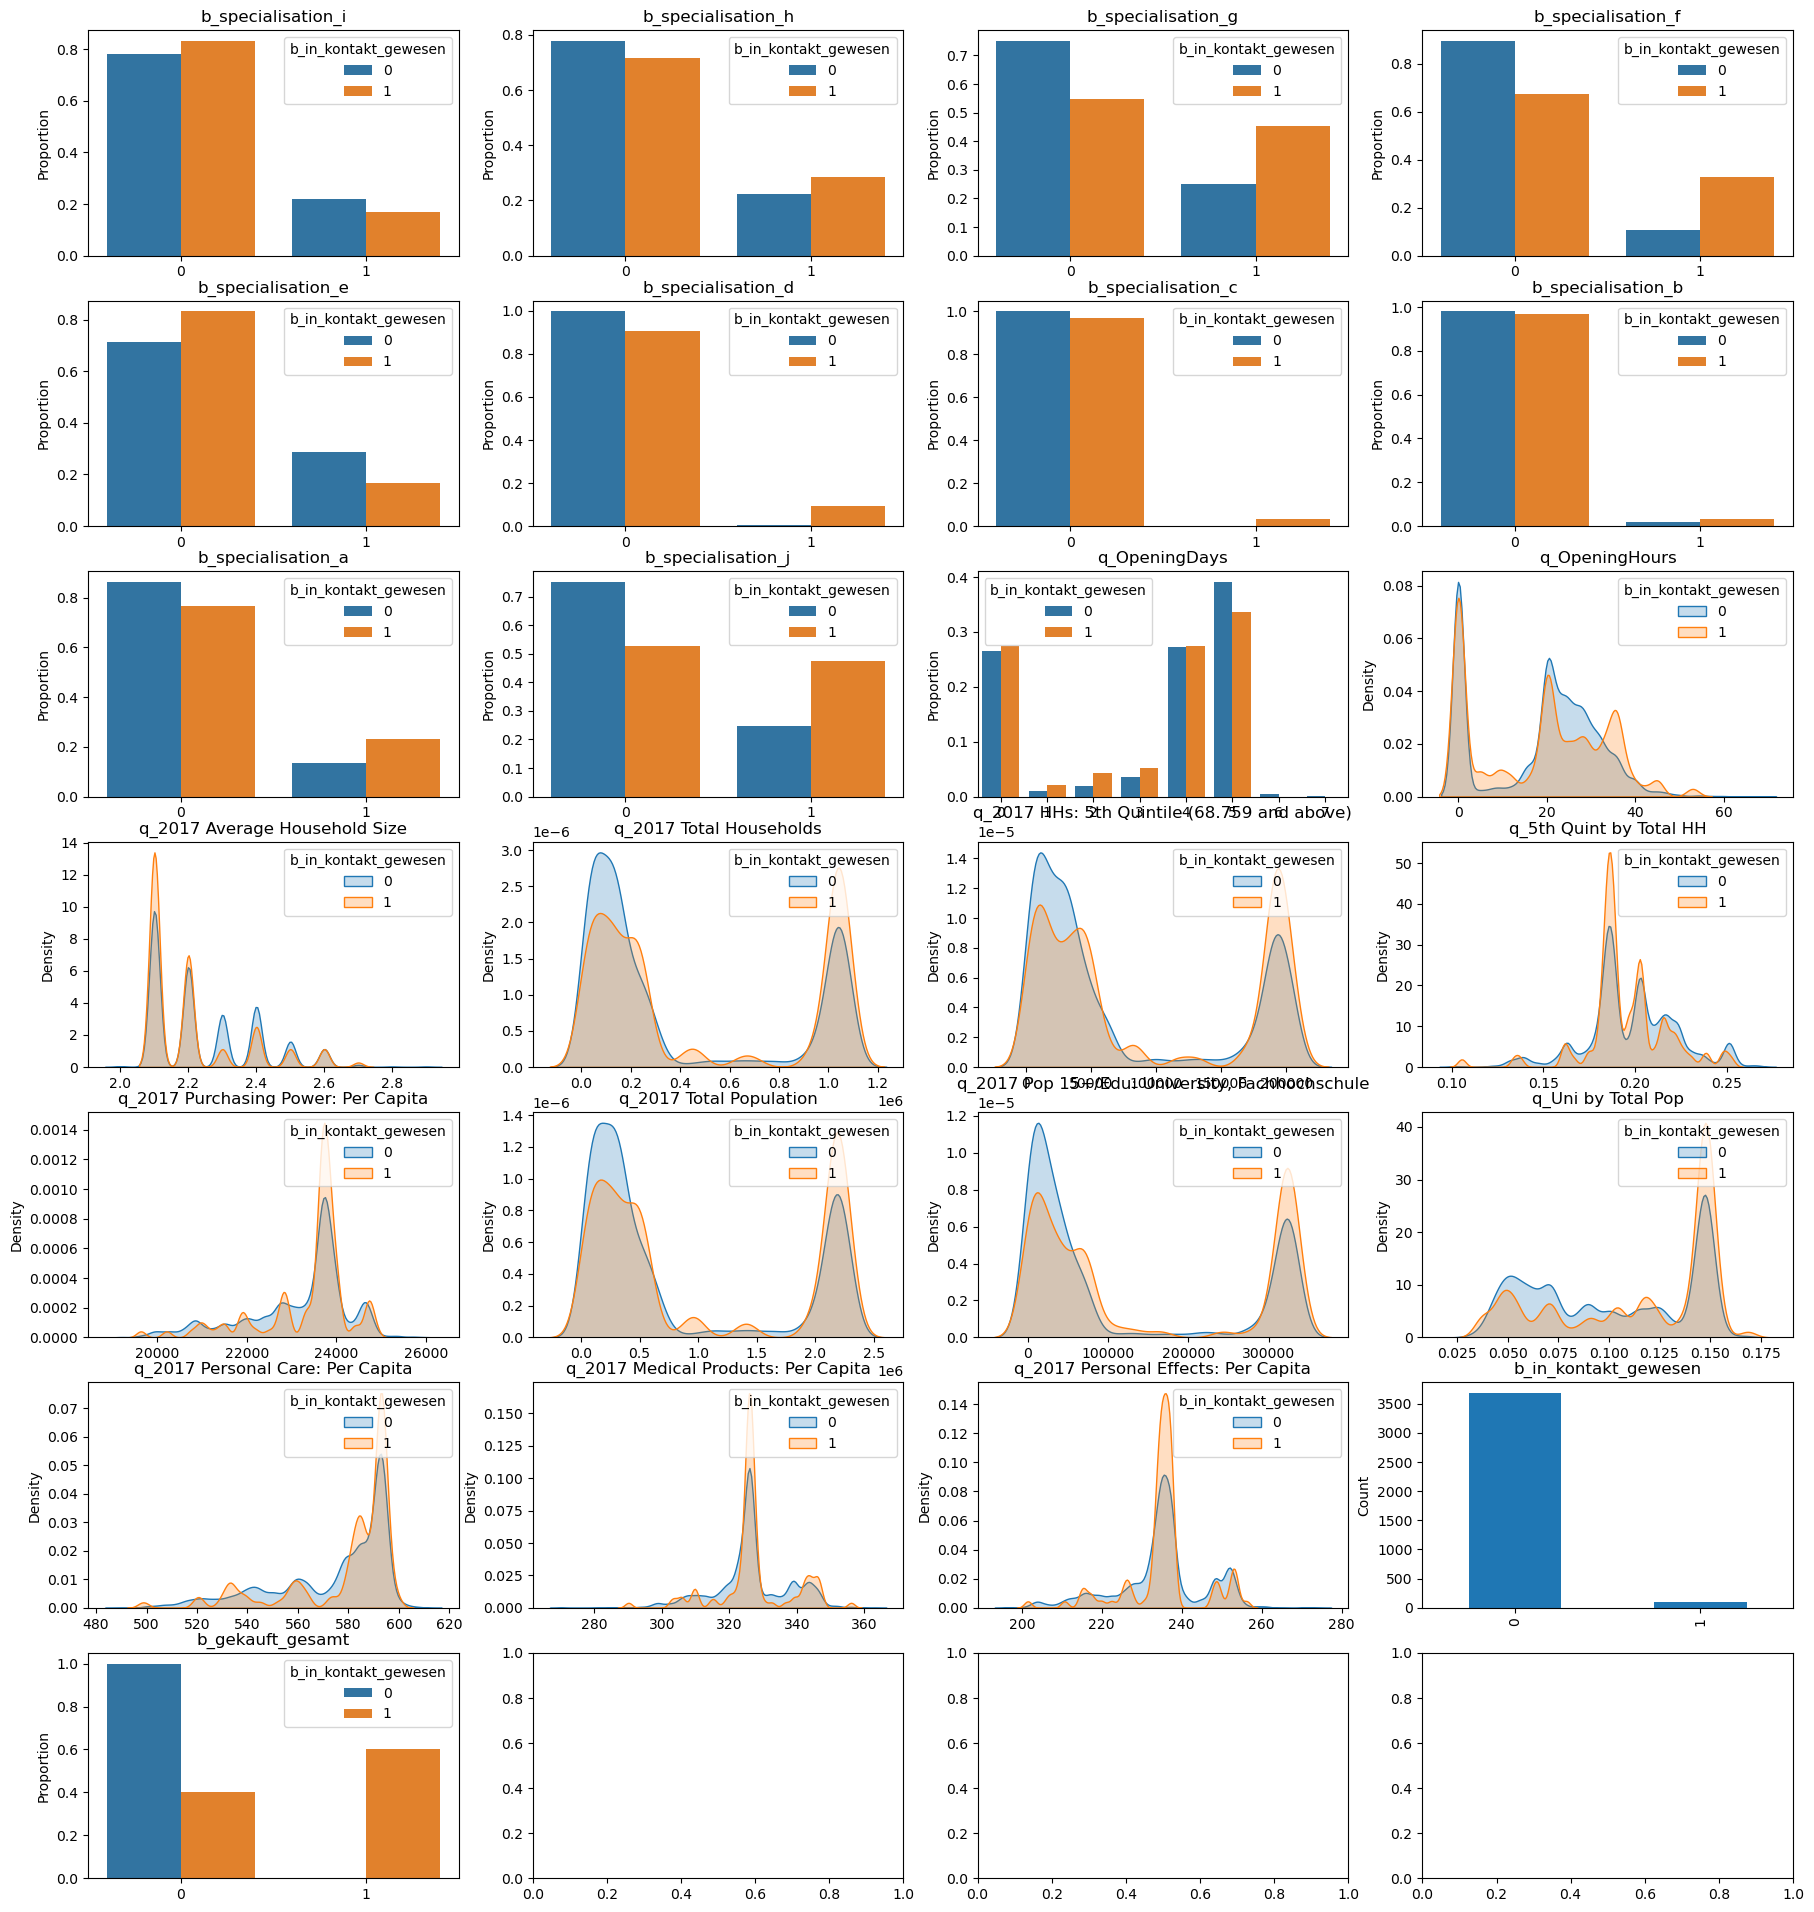

In [61]:
plot_describe(df, columns=df.drop(columns='fakeID').columns, hue='b_in_kontakt_gewesen')

Based on the visual inspection I assume that contacting potential customers happens at random (at least based on the provided features) since the distribution of the features across treated and non-treated observations looks quite similar for all features.

In [56]:
df_contact = df.loc[df.b_in_kontakt_gewesen==1,:]

In [57]:
df_contact.shape

(95, 26)

95 observations (small sample!) remain with 26 - `fakeID` - `b_in_kontakt_gewesen` - `b_gekauft_gesamt` = 23 potential predictors (features) at hand. Let's take a closer look at the potential features.

In [58]:
df.head().style

,fakeID,b_specialisation_i,b_specialisation_h,b_specialisation_g,b_specialisation_f,b_specialisation_e,b_specialisation_d,b_specialisation_c,b_specialisation_b,b_specialisation_a,b_specialisation_j,q_OpeningDays,q_OpeningHours,q_2017 Average Household Size,q_2017 Total Households,q_2017 HHs: 5th Quintile (68.759 and above),q_5th Quint by Total HH,q_2017 Purchasing Power: Per Capita,q_2017 Total Population,"q_2017 Pop 15+/Edu: University, Fachhochschule",q_Uni by Total Pop,q_2017 Personal Care: Per Capita,q_2017 Medical Products: Per Capita,q_2017 Personal Effects: Per Capita,b_in_kontakt_gewesen,b_gekauft_gesamt
0,1069_7334,0,0,0,0,0,0,0,0,0,1,4,36.000000,2.100000,1045481,195228,0.186735,23730.350000,2194057,324656,0.147971,593.190000,326.280000,235.750000,1,1
1,328_2350,0,0,0,1,1,1,0,0,0,0,4,20.000000,2.100000,935739,168291,0.179848,23343.260000,1966798,281130,0.142938,588.540000,320.360000,230.660000,1,1
2,865_6285,0,0,0,1,0,1,0,0,0,1,0,0.000000,2.100000,1026235,189787,0.184935,23674.180000,2149624,320326,0.149015,592.880000,325.570000,234.820000,1,1
3,47_307,0,1,1,0,0,0,0,0,0,0,4,20.000000,2.100000,1027701,189634,0.184523,23572.260000,2161445,310981,0.143876,590.840000,324.060000,233.810000,1,0
4,342_2513,0,0,0,0,0,1,0,0,0,1,5,33.000000,2.100000,1093324,207590,0.189871,23821.630000,2302959,334940,0.145439,593.560000,327.750000,237.410000,1,1


Looking at the column names and the respective values, I am going to make the following assumptions (clearly, for a business case these need to be closely aligned with the process owning department):
- we have a sample of commercial customers
- we have information on the commercial customer's business (`b_specialisation_*`, `q_Opening*`) and demographic information of the commercial customer's geographic location (`q_2017*`, `q_5th*`, ...)
- for the geographic features it seems reasonable to consider relative measures in the first place (i.e. `q_5th Quint by Total HH`, `q_Uni by Total Pop` and `*:Per Capita`)
- I also consider `q_2017 Total Households` to understand whether the mere size of the geographic reason has a high predictive power on purchases

In [59]:
df_contact_reduced = df_contact.drop(columns=['q_2017 HHs: 5th Quintile (68.759 and above)', 'q_2017 Pop 15+/Edu: University, Fachhochschule', 'q_2017 Total Population'])

<Axes: >

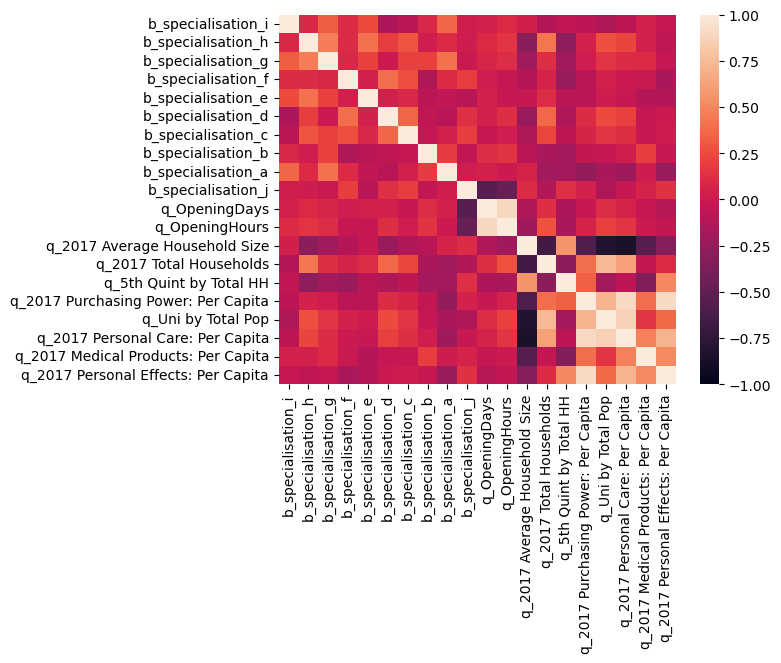

In [60]:
sns.heatmap(df_contact_reduced.drop(columns=['fakeID', 'b_in_kontakt_gewesen', 'b_gekauft_gesamt']).corr(), vmin=-1, vmax=1)

Cautious: `q_2017 Average Household Size` is strongly correlated with some of the other geographic features (e.g. `q_Uni by Total Pop`, `q_2017 Personal Care: Per Capita`).

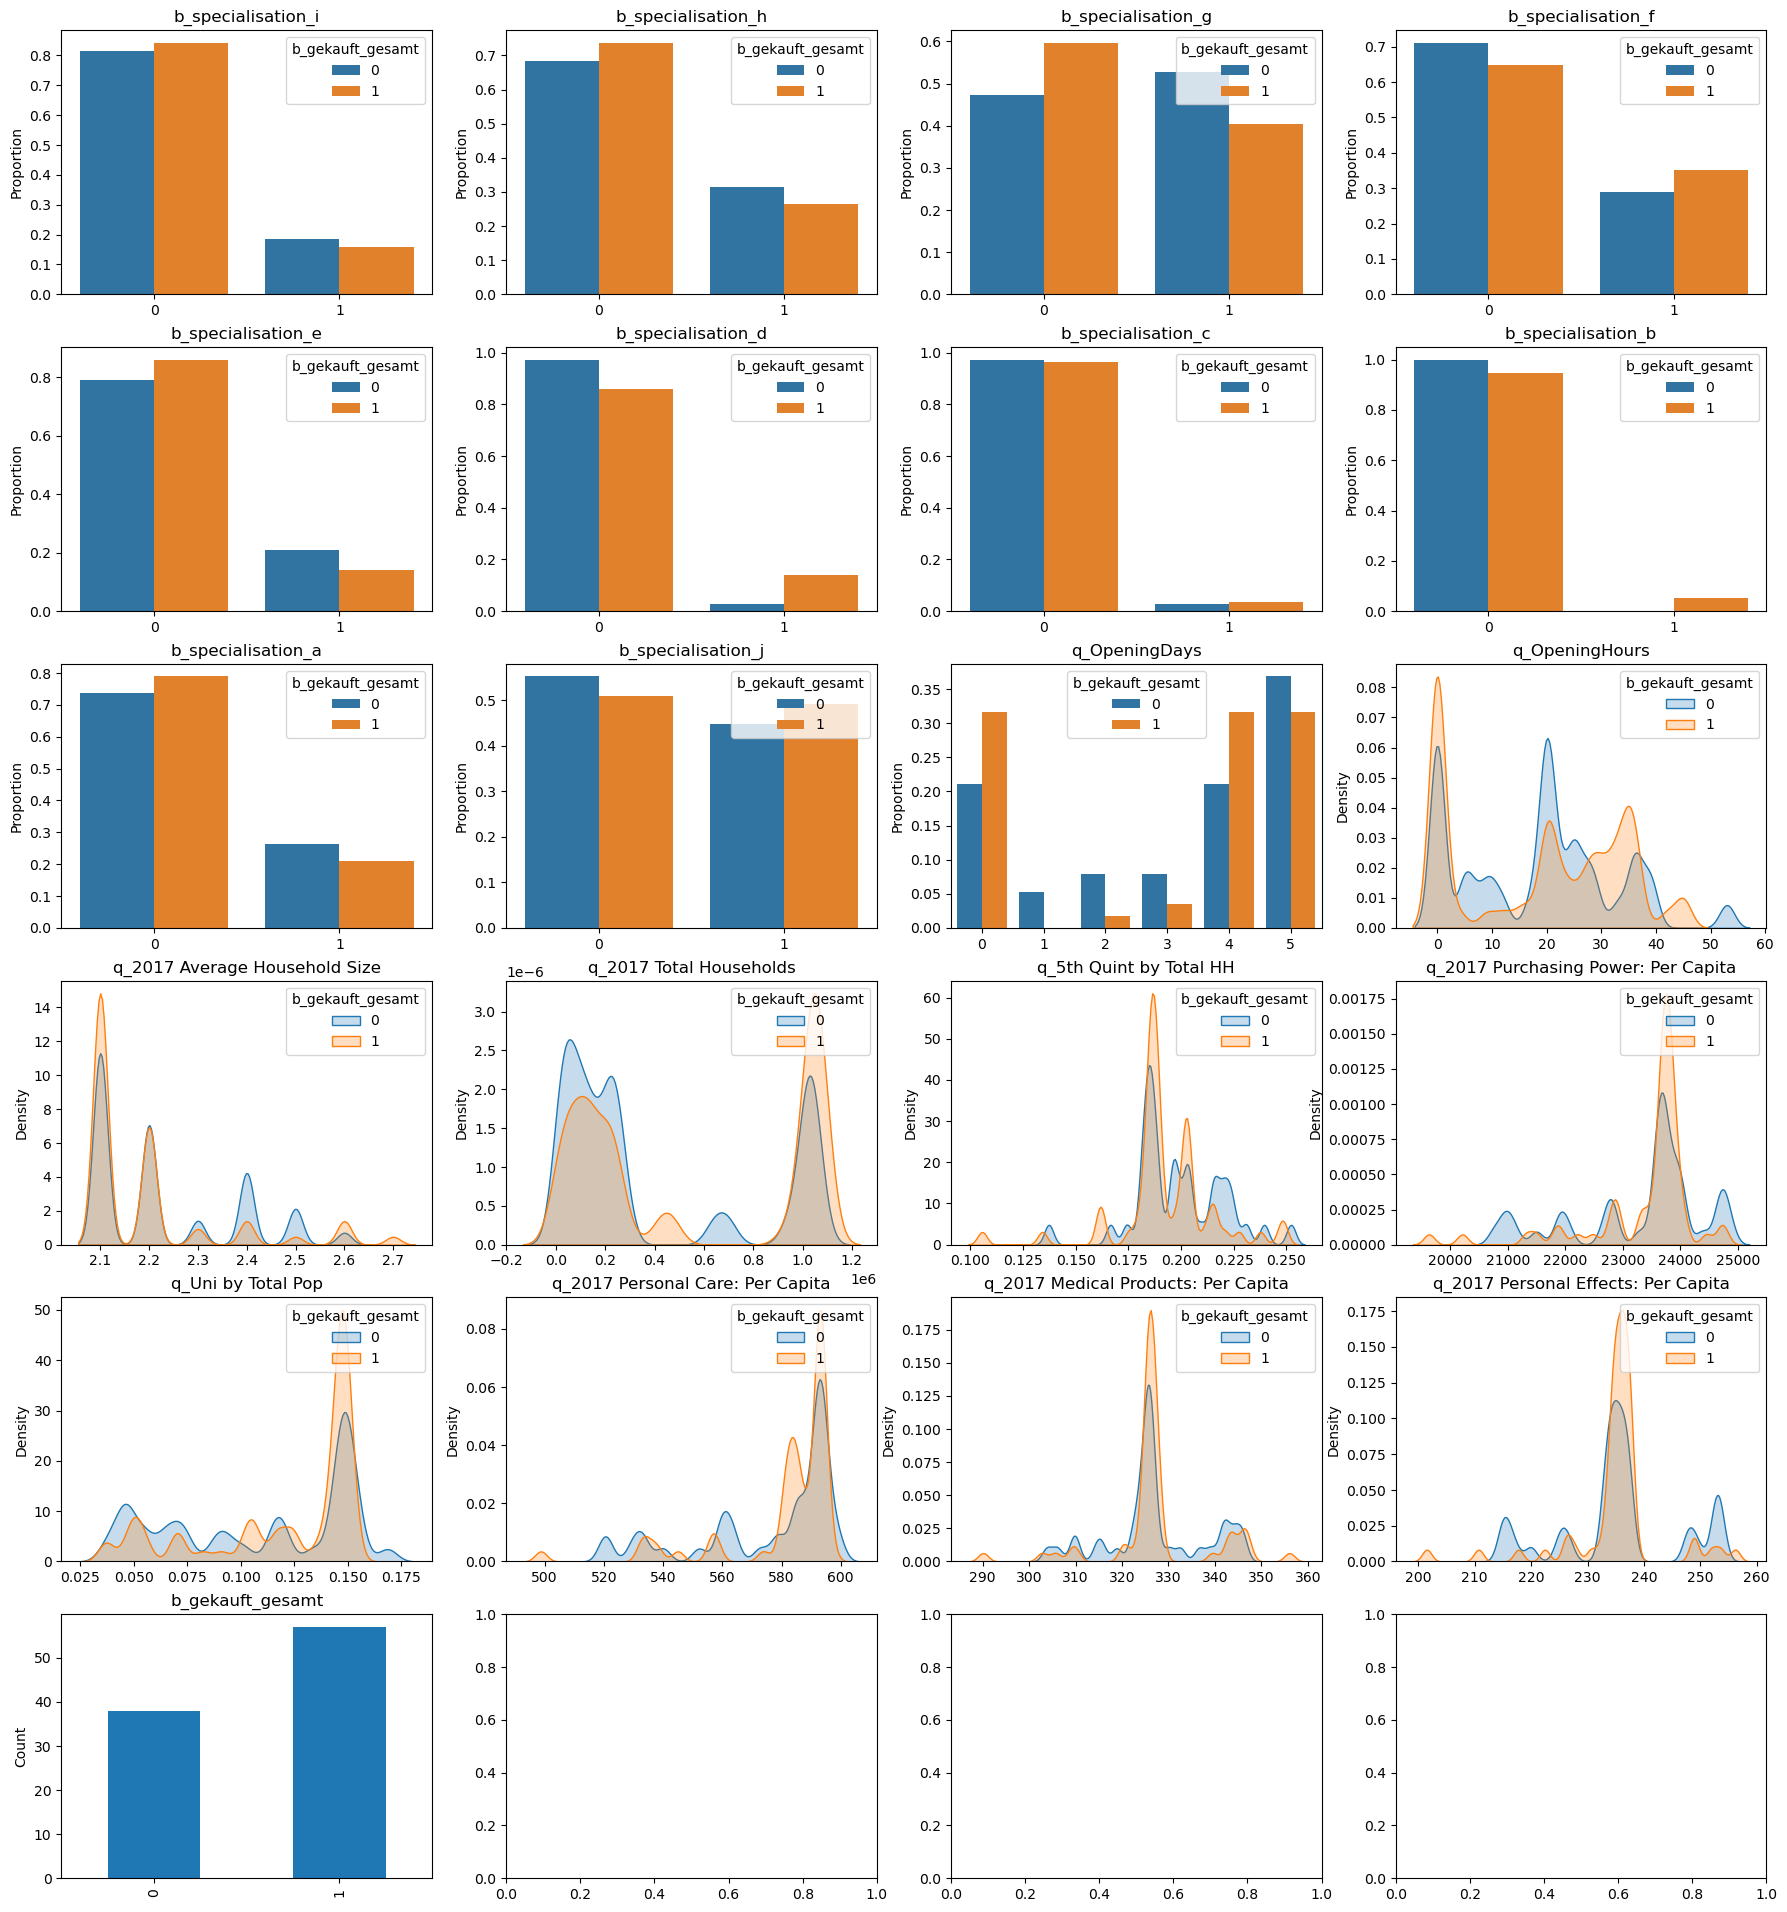

In [74]:
plot_describe(df_contact_reduced, columns=df_contact_reduced.drop(columns=['fakeID', 'b_in_kontakt_gewesen']).columns, hue='b_gekauft_gesamt')

## Which features drive the purchase decision?

To answer this question we choose a logistic regression with a regularizer for automatic feature selection. First of all, this allows us to judge whether the influence of the selected features are statistically significant. Given the small sample size this important to consider especially when aiming at the development of a predictive model for the priorization of customers in lead generation. For such a predictive model we run into the risk that the sample may not be representative or that the performance metrics resulting from an even smaller test set may not be representative either. However, if we find on the small sample statistically significant correlations between certain features and the target variable, we can be more confident in developing a model that is tuned for out-of-sample prediction. Note, for this first step I do not do a split into training and test sets but rather focus on the statistical significance therefore trying to get the most out of the small sample size.

In [95]:
X = df_contact_reduced.drop(columns=['fakeID', 'b_in_kontakt_gewesen', 'b_gekauft_gesamt', 'b_specialisation_b'])
y = df_contact_reduced['b_gekauft_gesamt']

In [96]:
# Add a constant column to the predictor variables for statsmodels
X = sm.add_constant(X)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X)
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.550862
         Iterations 6


In [97]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       b_gekauft_gesamt   No. Observations:                   95
Model:                          Logit   Df Residuals:                       75
Method:                           MLE   Df Model:                           19
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                  0.1815
Time:                        19:00:48   Log-Likelihood:                -52.332
converged:                       True   LL-Null:                       -63.936
Covariance Type:            nonrobust   LLR p-value:                    0.2283
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                -120.6223     66.382     -1.817      0.069    -250.728       9.483
b_specialisation_i                      0.4598      0.792      0.581      0.561      -1.092       2.012
b_specialisation_h                     -0.9627      0.768     -1.254      0.210      -2.468       0.542
b_specialisation_g                     -0.6279      0.641     -0.980      0.327      -1.883       0.628
b_specialisation_f                     -0.1117      0.607     -0.184      0.854      -1.302       1.079
b_specialisation_e                     -0.3278      0.786     -0.417      0.677      -1.868       1.213
b_specialisation_d                      1.8296      1.344      1.361      0.173      -0.805       4.464
b_specialisation_c                     -0.2553      1.626     -0.157      0.875      -3.441       2.931
b_specialisation_a                      0.2431      0.704      0.345      0.730      -1.136       1.623
b_specialisation_j                     -0.0092      0.653     -0.014      0.989      -1.288       1.270
q_OpeningDays                          -0.0769      0.309     -0.249      0.803      -0.682       0.528
q_OpeningHours                          0.0014      0.045      0.032      0.975      -0.086       0.089
q_2017 Average Household Size          27.2960     11.094      2.460      0.014       5.552      49.040
q_2017 Total Households             -3.909e-07   1.36e-06     -0.287      0.774   -3.06e-06    2.28e-06
q_5th Quint by Total HH               -96.5019     95.901     -1.006      0.314    -284.465      91.461
q_2017 Purchasing Power: Per Capita    -0.0038      0.003     -1.192      0.233      -0.010       0.002
q_Uni by Total Pop                     41.1957     25.989      1.585      0.113      -9.741      92.133
q_2017 Personal Care: Per Capita        0.2099      0.130      1.620      0.105      -0.044       0.464
q_2017 Medical Products: Per Capita    -0.0407      0.143     -0.285      0.776      -0.321       0.240
q_2017 Personal Effects: Per Capita     0.2425      0.359      0.675      0.499      -0.461       0.946
=======================================================================================================
"""

In [102]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(penalty='l2', random_state=333))
])

In [103]:
pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=333))])

In [105]:
results_regularized = pd.DataFrame({'Feature': pipeline.feature_names_in_, 'Coefficient_estimate': pipeline.named_steps['classifier'].coef_[0]}).round(decimals=5)

In [107]:
results_regularized.loc[np.abs(results_regularized.Coefficient_estimate)>0.2]

,Feature,Coefficient_estimate
2,b_specialisation_h,-0.26466
3,b_specialisation_g,-0.25626
6,b_specialisation_d,0.45505
12,q_2017 Average Household Size,0.95604
13,q_2017 Total Households,0.22310
14,q_5th Quint by Total HH,-0.72182
15,q_2017 Purchasing Power: Per Capita,-0.23136
16,q_Uni by Total Pop,0.41834
17,q_2017 Personal Care: Per Capita,0.64883


In [108]:
X_reduced = df_contact_reduced[results_regularized.loc[np.abs(results_regularized.Coefficient_estimate)>0.2].Feature]

In [112]:
# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X_reduced)
results = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.614629
         Iterations 6


In [113]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:       b_gekauft_gesamt   No. Observations:                   95
Model:                          Logit   Df Residuals:                       86
Method:                           MLE   Df Model:                            8
Date:                Thu, 01 Feb 2024   Pseudo R-squ.:                 0.08675
Time:                        19:08:36   Log-Likelihood:                -58.390
converged:                       True   LL-Null:                       -63.936
Covariance Type:            nonrobust   LLR p-value:                    0.1965
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
b_specialisation_h                     -0.7748      0.643     -1.204      0.229      -2.036       0.486
b_specialisation_g                     -0.5186      0.506     -1.025      0.306      -1.511       0.473
b_specialisation_d                      1.5611      1.148      1.360      0.174      -0.688       3.810
q_2017 Average Household Size           1.4722      3.731      0.395      0.693      -5.841       8.785
q_2017 Total Households              4.139e-07   1.01e-06      0.411      0.681   -1.56e-06    2.39e-06
q_5th Quint by Total HH               -12.3860     46.249     -0.268      0.789    -103.032      78.259
q_2017 Purchasing Power: Per Capita    -0.0004      0.002     -0.200      0.842      -0.004       0.004
q_Uni by Total Pop                     10.2391     12.936      0.791      0.429     -15.116      35.594
q_2017 Personal Care: Per Capita        0.0137      0.078      0.174      0.861      -0.140       0.167
=======================================================================================================
"""